In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import xgboost as xgb
from datetime import datetime
from scipy import stats

In [3]:
sn.set_style('whitegrid')
path = 'data/'

In [4]:
trainData = pd.read_csv(path+'train.csv')
testData = pd.read_csv(path+'test.csv')

In [5]:
trainData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [6]:
trainData.shape

(10886, 12)

In [7]:
trainData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### Из описания датасета:
<br>datetime - hourly date + timestamp  
season:  
>1 = spring,<br>2 = summer,<br>3 = fall,<br>4 = winter

holiday - whether the day is considered a holiday
<br>workingday - whether the day is neither a weekend nor holiday
<br>weather:
>1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds,Mist<br>3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br>4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius
<br>atemp - "feels like" temperature in Celsius
<br>humidity - relative humidity
<br>windspeed - wind speed
<br>casual - number of non-registered user rentals initiated
<br>registered - number of registered user rentals initiated
<br>count - number of total rentals

Для начала визуализируем распределение и среднее (скользящее среднее) количество арендованных велосипедов за всё время

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  app.launch_new_instance()


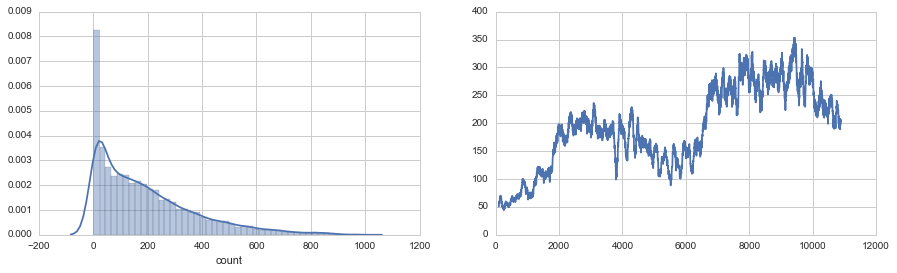

In [8]:
fig, axes = plt.subplots(figsize=(15, 4), ncols=2, nrows=1)
sn.distplot(trainData["count"],ax=axes[0])
plt.plot(pd.rolling_mean(trainData['count'], 100))
plt.show()

Учитывая форму распределения, перейдём к логарифмам. Таким образом распределение заметно сгладится.

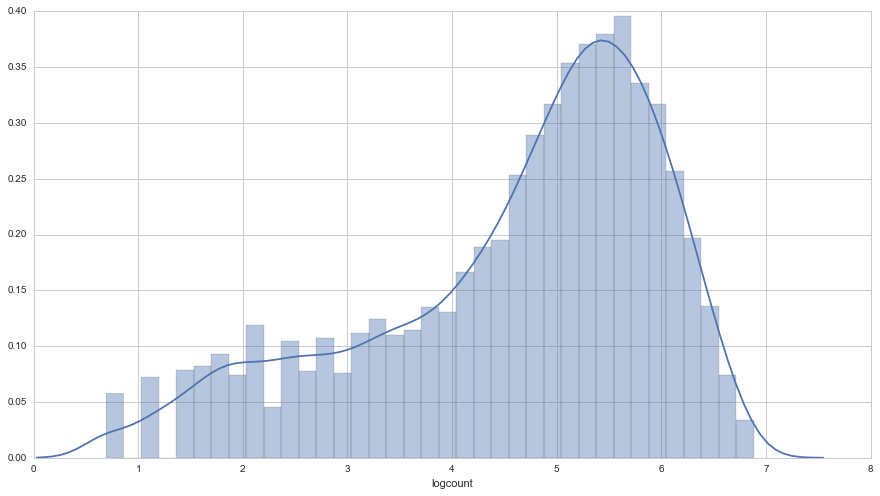

In [9]:
trainData['logcount'] = trainData['count'].apply(lambda x: np.log1p(x))
fig, axes = plt.subplots(figsize=(15, 8))
sn.distplot(trainData["logcount"], ax=axes)

Первый этап feature engineering'а: разбираем дату-время на отдельные признаки, которые можно не только отправлять в регрессор, но и анализировать

In [11]:
trainData['date'] = trainData.datetime.apply(lambda x : x.split()[0])
trainData['hour'] = trainData.datetime.apply(lambda x : x.split()[1].split(":")[0])
trainData['weekday'] = trainData.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').weekday())
trainData['month'] = trainData.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').month)

testData['date'] = testData.datetime.apply(lambda x : x.split()[0])
testData['hour'] = testData.datetime.apply(lambda x : x.split()[1].split(":")[0])
testData['weekday'] = testData.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').weekday())
testData['month'] = testData.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').month)

timeColumn = testData['datetime']

Уже на этом этапе можно попробовать обучить XGBoost и посмотреть, что из этого выйдет. Спойлер: примерно 0.465. Гиперпараметры немного подтюнены заранее.

In [12]:
X = trainData.drop(['count', 'datetime', 'registered', 'casual', 'date', 'logcount'], axis=1).values
Y = trainData['logcount'].values

testX = testData.drop(['datetime', 'date'], axis=1).values

trainMatrix = xgb.DMatrix(X, label=Y)

max_depth = 5
min_child_weight = 8
subsample = 0.9
num_estimators = 1000
learning_rate = 0.1

clf = xgb.XGBRegressor(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                n_estimators=num_estimators,
                learning_rate=learning_rate)

clf.fit(X,Y)

pred = clf.predict(testX)
pred = np.expm1(pred)

submission = pd.DataFrame({
        "datetime": timeColumn,
        "count": pred
    })
submission.to_csv('XGBwithNoFE.csv', index=False)

Допустим, нам данной точности мало. Будем разбирать, что у нас с данными. Возможно, есть какие-то внутренние закономерности, что-то можно отбросить, что-то добавить. Строим графики.
Во-первых, нужно распределение по рабочим-нерабочим дням, сезонам и по часам в течение суток

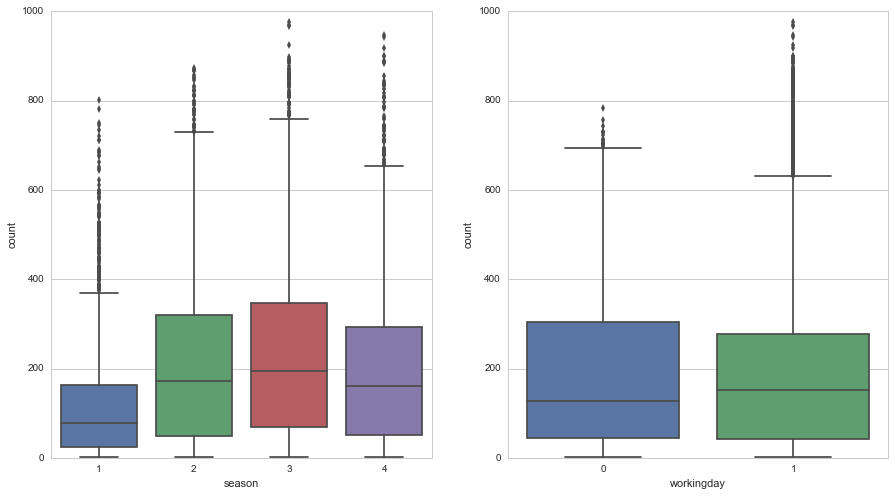

In [13]:
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(15, 8)
sn.boxplot(data=trainData, y='count', x='season', ax=axes[0])
sn.boxplot(data=trainData, y='count', x='workingday', ax=axes[1])
axes[0].set(xlabel='season', ylabel='count')
axes[1].set(xlabel='workingday', ylabel='count')

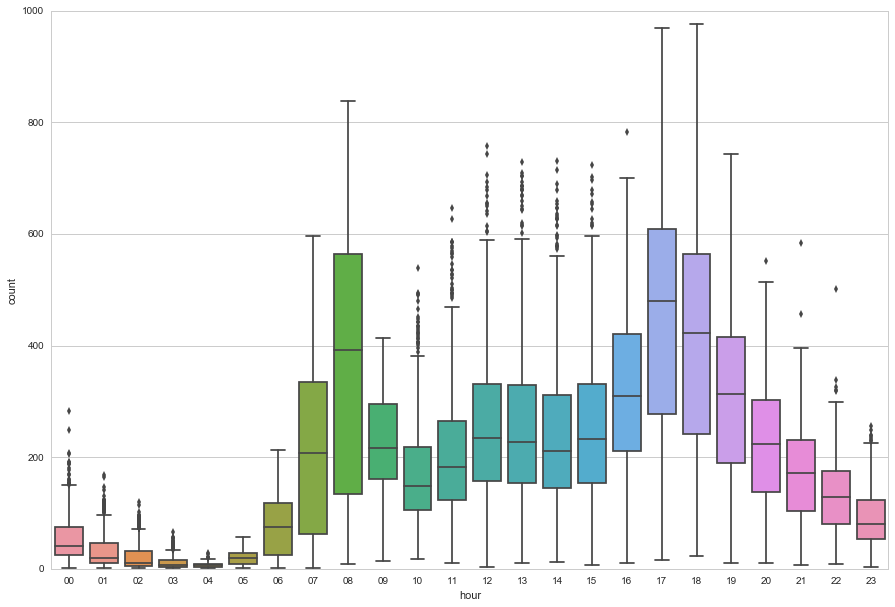

In [14]:
fix, axes = plt.subplots(figsize=(15, 10))
sn.boxplot(data=trainData, y='count', x='hour', ax=axes)

Воспользуемся правилом трёх сигм, чтобы "очистить" распределение от тех значений, которые можно принять за аномальные (в контексте формы распределения). В дальнейшем видно, что мы избавились примерно от 1% данных, но на качество работы классификатора это скажется заметнее.

In [15]:
trainDataWithoutOutliers = trainData[np.abs(trainData['count']-trainData['count'].mean())
                                     <=(3*trainData['count'].std())] 
print(trainDataWithoutOutliers.shape)
trainData = trainDataWithoutOutliers

(10739, 17)


Определим корреляцию признаков и попробуем определить зависимость количества арендованных байков от некоторых признаков. Составим список тех, которые целесообразно отбросить. 

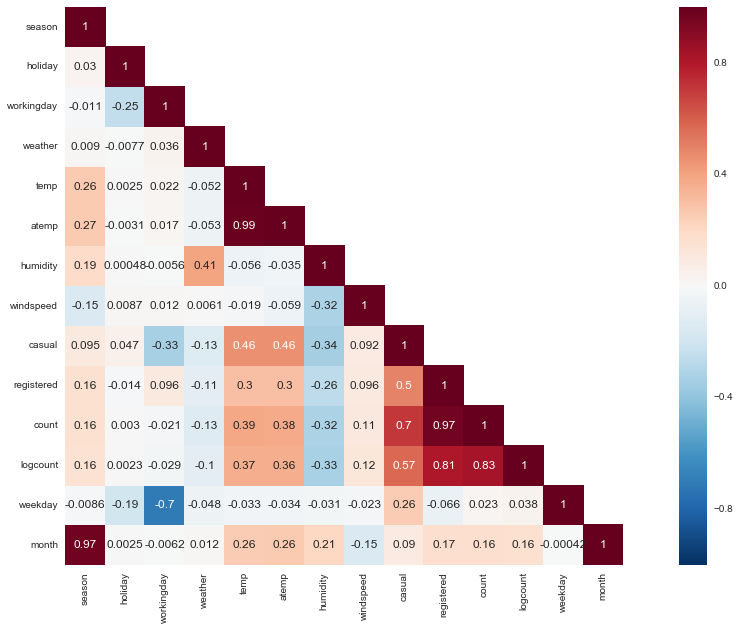

In [18]:
corrMat = trainData.corr()
mask = np.array(corrMat)
mask[np.tril_indices_from(mask)] = False
fig, ax= plt.subplots(figsize=(20, 10))
sn.heatmap(corrMat, mask=mask,vmax=1., square=True,annot=True)

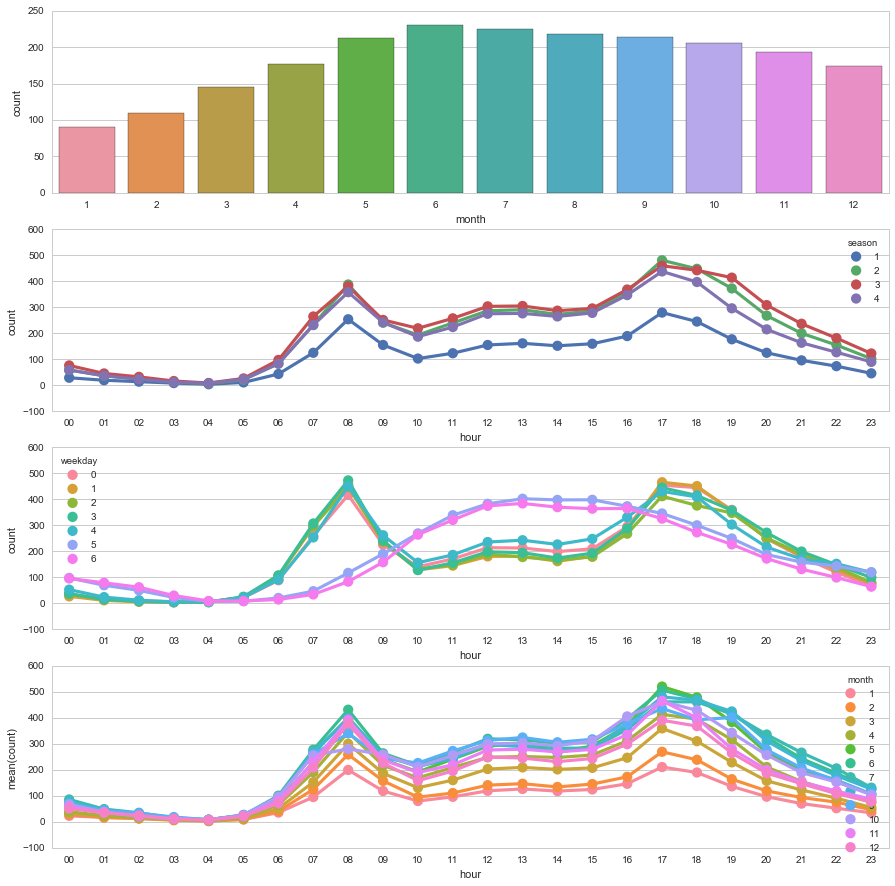

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 15))

meanMonthly = pd.DataFrame(trainData.groupby('month')['count'].mean()).reset_index().sort_values(by='count', ascending=False)
sn.barplot(data=meanMonthly, x='month', y='count', ax=axes[0])
axes[0].set(xlabel='month', ylabel='count')

hoursSeasonly = pd.DataFrame(trainData.groupby(['hour', 'season'], sort=True)['count'].mean()).reset_index()
sn.pointplot(x=hoursSeasonly['hour'], y=hoursSeasonly['count'], hue=hoursSeasonly['season'], data=hoursSeasonly, join=True, ax=axes[1])
axes[1].set(xlabel='hour', ylabel='count')

hoursDayly = pd.DataFrame(trainData.groupby(['hour','weekday'], sort=True)['count'].mean()).reset_index()
sn.pointplot(x=hoursDayly['hour'], y=hoursDayly['count'], hue=hoursDayly['weekday'], data=hoursDayly, join=True,ax=axes[2])
axes[2].set(xlabel='hour', ylabel='count')

hoursSeasonly = pd.DataFrame(trainData.groupby(['hour', 'month'], sort=True)['count'].mean()).reset_index()
sn.pointplot(x=hoursSeasonly['hour'], y=hoursSeasonly['count'], hue=hoursSeasonly['month'], data=hoursSeasonly, join=True, ax=axes[3])
axes[1].set(xlabel='hour', ylabel='count')

Перейдём к feature engineering'у

In [63]:
X = trainData.drop(['date', 'temp', 'casual', 'registered', 'logcount', 'datetime', 'count'], axis=1)

season_df = pd.get_dummies(trainData['season'], prefix='s', drop_first=True)
weather_df = pd.get_dummies(trainData['weather'], prefix='w', drop_first=True)
hour_df = pd.get_dummies(trainData['hour'], prefix='h', drop_first=True)
weekday_df = pd.get_dummies(trainData['weekday'], prefix='d', drop_first=True)
month_df = pd.get_dummies(trainData['month'], prefix='m', drop_first=True)

X = X.join(season_df)
X = X.join(weather_df)
X = X.join(hour_df)
X = X.join(weekday_df)
X = X.join(month_df)

X = X.values
Y=trainData['logcount'].values
print(X.shape)

testX = testData.drop(['date', 'temp', 'datetime'], axis=1)

season_df = pd.get_dummies(testData['season'], prefix='s', drop_first=True)
weather_df = pd.get_dummies(testData['weather'], prefix='w', drop_first=True)
hour_df = pd.get_dummies(testData['hour'], prefix='h', drop_first=True)
weekday_df = pd.get_dummies(testData['weekday'], prefix='d', drop_first=True)
month_df = pd.get_dummies(testData['month'], prefix='m', drop_first=True)

testX = testX.join(season_df)
testX = testX.join(weather_df)
testX = testX.join(hour_df)
testX = testX.join(weekday_df)
testX = testX.join(month_df)

testX = testX.values
print(testX.shape)

(10739, 56)

In [65]:
clf=xgb.XGBRegressor(max_depth=8,min_child_weight=6,gamma=0.4,colsample_bytree=0.6,subsample=0.6)
clf.fit(X,Y)

pred = clf.predict(testX)
pred = np.expm1(pred)

submission = pd.DataFrame({
        "datetime": timeColumn,
        "count": pred
    })
submission.to_csv('XGBwithFE.csv', index=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=6, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)